In [1]:
import torch
import torch_geometric

import rdkit

In [2]:
from torch_geometric.datasets import MoleculeNet
data = MoleculeNet(root=".", name="ESOL") 
data  


ESOL(1128)

In [3]:
print("dataset type: ", type(data))
print("dataset features: ", data.num_features)
print("dataset target ", data.num_classes)
print("dataset length: ", data.len)

print("dataset sample: ", data[0])
print("sample nodes: ", data[0].num_nodes)
print("sample edges: ", data[0].num_edges)

dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
dataset features:  9
dataset target  734
dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
sample nodes:  32
sample edges:  68


d:\Softwares\miniconda\Lib\site-packages\torch_geometric\data\dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


In [4]:
'''
smiles - representation of molecules 
edge_index - graph connections. shape = [2, num_edges]
x = node features ( number of nodes with 9 features per node). shape = [num_nodes, num_node_features]
y = labels
'''
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [5]:
data[0].edge_index.t() #edges in sparse COO format

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [6]:
data[0].y

tensor([[-0.7700]])

In [7]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

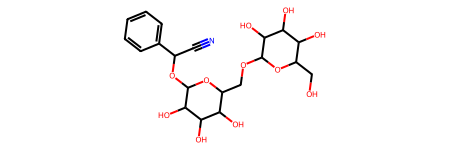

In [8]:
from rdkit import Chem  
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [9]:
type(molecule)

rdkit.Chem.rdchem.Mol

In [17]:
# model
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp 

embedding_size = 64

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        
        self.initial_conv = GATConv(data.num_features, embedding_size)
        self.conv1 = GATConv(embedding_size, embedding_size, heads=3)
        self.conv2 = GATConv(embedding_size*3, embedding_size)
        
        
        self.out = Linear(embedding_size*2, 1) #emb*2 because concating gap and gmp
        
    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        
        
        # global pooling (stack/concat different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)
        
        out = self.out(hidden)
        
        return out, hidden
    
model = GAT()
print(model)
print("number of parameters: ", sum(p.numel() for p in model.parameters()))

GAT(
  (initial_conv): GATConv(9, 64, heads=1)
  (conv1): GATConv(64, 64, heads=3)
  (conv2): GATConv(192, 64, heads=1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
number of parameters:  26241


In [18]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

learning_rate = 0.0005
batch_size = 64
num_epochs = 2000

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data_size = len(data)
train_size = int(0.9 * data_size)
val_size = data_size - train_size
train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        shuffle=False)

def train(data):
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = criterion(pred, batch.y)
        loss.backward()
        optimizer.step()
        
    return loss, embedding  

losses = []
for epoch in range(num_epochs):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"epoch {epoch} | training loss {loss}")
        

epoch 0 | training loss 6.004523754119873
epoch 100 | training loss 0.5688886642456055
epoch 200 | training loss 0.8916506171226501
epoch 300 | training loss 0.5918946266174316
epoch 400 | training loss 0.28712260723114014
epoch 500 | training loss 0.3510112166404724
epoch 600 | training loss 0.2916595935821533
epoch 700 | training loss 0.2853054404258728
epoch 800 | training loss 0.28926700353622437
epoch 900 | training loss 0.19520798325538635
epoch 1000 | training loss 0.21973393857479095
epoch 1100 | training loss 0.16335703432559967
epoch 1200 | training loss 0.09546241164207458
epoch 1300 | training loss 0.16469767689704895
epoch 1400 | training loss 0.1406305730342865
epoch 1500 | training loss 0.10706105083227158
epoch 1600 | training loss 0.08563200384378433
epoch 1700 | training loss 0.057157002389431
epoch 1800 | training loss 0.057439133524894714
epoch 1900 | training loss 0.04630505293607712


<Axes: >

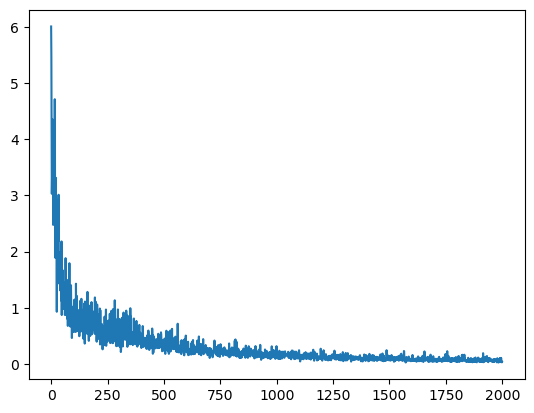

In [19]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt

In [20]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(val_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-0.770,-4.298573
1,-1.614,-1.538565
2,-1.130,-2.531739
3,-4.445,-4.503748
4,-1.770,-1.165981
...,...,...
59,-2.550,-2.621684
60,-0.240,-0.298910
61,-7.870,-9.057948
62,-3.140,-2.101942


<Axes: xlabel='y_real', ylabel='y_pred'>

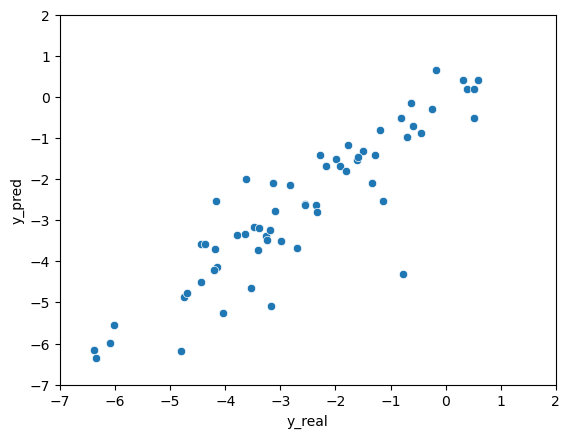

In [21]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt